In [3]:
import os
import requests
import pandas as pd
import plotly.express as px
import folium

AGGREGATED_REGIONS = [
    "CAL",
    "CAR",
    "CENT",
    "FLA",
    "MIDA",
    "MIDW",
    "NE",
    "NW",
    "NY",
    "SE",
    "SW",
    "TEN",
    "TEX",
    "US48",
]

EIA_API_KEY = os.getenv("EIA_API_KEY")
if not EIA_API_KEY:
    raise EnvironmentError("Please set your EIA_API_KEY environment variable.")

url = "https://api.eia.gov/v2/electricity/rto/region-data/data/"
params = {
    "api_key": EIA_API_KEY,
    "frequency": "hourly",
    "data[0]": "value",
    "sort[0][column]": "period",
    "sort[0][direction]": "desc",
    "offset": 0,
    "length": 5000,
}
params["facets[respondent][]"] = AGGREGATED_REGIONS

try:
    resp = requests.get(url, params=params)
    resp.raise_for_status()
    data = resp.json()["response"]["data"]
    df = pd.DataFrame(data)
    df.to_csv("eia_hourly_cached.csv", index=False)
except Exception as exc:
    cache_path = "eia_hourly_cached.csv"
    if not os.path.exists(cache_path):
        raise RuntimeError("Failed to download data and no cached file was found.") from exc
    print(f"⚠️ Using cached data because API request failed: {exc}")
    df = pd.read_csv(cache_path)

df["region"] = df["respondent"]
df.head()




,period,respondent,respondent-name,type,type-name,value,value-units,region
0,2025-11-09T08,CAL,California,DF,Day-ahead demand forecast,25823,megawatthours,CAL
1,2025-11-09T08,NW,Northwest,DF,Day-ahead demand forecast,21602,megawatthours,NW
2,2025-11-09T08,US48,United States Lower 48,DF,Day-ahead demand forecast,47425,megawatthours,US48
3,2025-11-09T07,CAL,California,DF,Day-ahead demand forecast,26947,megawatthours,CAL
4,2025-11-09T07,NW,Northwest,DF,Day-ahead demand forecast,36660,megawatthours,NW


In [4]:
df = df.copy()
df["region"] = df["respondent"]
df["datetime"] = pd.to_datetime(df["period"])
df["demand_MW"] = pd.to_numeric(df["value"], errors="coerce")

latest_idx = df.groupby("region")["datetime"].idxmax()
latest_df = df.loc[latest_idx].copy()
usage = latest_df[["region", "demand_MW", "datetime"]]
latest_time = usage["datetime"].max() # <--Grab the latest data


In [5]:
# ======================================================
# 2️⃣ Region → state mapping (unchanged)
# ======================================================
region_to_states = {
    "CAL": ["California"],
    "CAR": ["North Carolina", "South Carolina"],
    "CENT": ["Arkansas", "Kansas", "Louisiana", "Missouri", "Nebraska", "Oklahoma"],
    "FLA": ["Florida"],
    "MIDA": ["Delaware", "District of Columbia", "Maryland", "New Jersey", "Pennsylvania", "Virginia", "West Virginia"],
    "MIDW": ["Illinois", "Indiana", "Iowa", "Kentucky", "Michigan", "Minnesota", "North Dakota", "Ohio", "South Dakota", "Wisconsin"],
    "NE": ["Connecticut", "Maine", "Massachusetts", "New Hampshire", "Rhode Island", "Vermont"],
    "NY": ["New York"],
    "NW": ["Idaho", "Montana", "Oregon", "Washington", "Wyoming"],
    "SE": ["Alabama", "Georgia", "Mississippi"],
    "SW": ["Arizona", "Colorado", "New Mexico", "Nevada", "Utah"],
    "TEN": ["Tennessee"],
    "TEX": ["Texas"],
}

usage = usage[usage["region"].isin(region_to_states)].copy()
usage["state_list"] = usage["region"].map(region_to_states)
usage = usage.explode("state_list").rename(columns={"state_list": "state"})



In [7]:
# ======================================================
# 3️⃣ Choropleth via Folium (OpenStreetMap)
# ======================================================
geo_url = "https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json"

m = folium.Map(location=[39.5, -98.35], zoom_start=4, tiles="CartoDB positron")

choropleth = folium.Choropleth(
    geo_data=geo_url,
    name="Electricity Demand (MW)",
    data=usage,
    columns=["state", "demand_MW"],
    key_on="feature.properties.name",
    fill_color="YlOrRd",
    fill_opacity=0.8,
    line_opacity=0.3,
    nan_fill_color="gray",
    legend_name=f"Electricity Demand (MW) — {latest_time:%Y-%m-%d %H:%M}",
).add_to(m)

# ✅ tooltip must attach to a GeoJson object, not the map
folium.GeoJson(
    geo_url,
    name="State Boundaries",
    tooltip=folium.GeoJsonTooltip(
        fields=["name"],
        aliases=["State:"],
        localize=True
    )
).add_to(m)

folium.LayerControl().add_to(m)

m

In [28]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np

def forecast_region(df_region, horizon=24):  # one day = 24 hours
    """Forecast next-day electricity demand for a given region."""
    df_region = df_region.drop_duplicates(subset=["datetime"]).copy()
    s = (
        df_region.set_index("datetime")["demand_MW"]
        .asfreq("h")
        .interpolate("time")
    )

    # Light scaling to stabilize the fit
    s_scaled = s / 1000.0

    # Fit daily-seasonal SARIMA
    model = SARIMAX(
        s_scaled,
        order=(2, 0, 2),
        seasonal_order=(1, 1, 1, 24),
        trend="c",
        enforce_stationarity=False,
        enforce_invertibility=False
    )

    try:
        fit = model.fit(disp=False)
    except Exception as e:
        print(f"⚠️ SARIMA failed for {df_region['region'].iloc[0]} ({e}), using fallback.")
        # Simple fallback ARIMA if SARIMA fails
        model = SARIMAX(s_scaled, order=(1, 0, 0), trend="c")
        fit = model.fit(disp=False)

    # Predict next day (24h)
    forecast_obj = fit.get_forecast(steps=horizon)
    yhat = forecast_obj.predicted_mean * 1000.0

    # Align forecast start with last observation
    if len(yhat) > 0:
        offset = float(s.iloc[-1] - yhat.iloc[0])
        yhat = yhat + offset

    # Clip to realistic non-negative range
    yhat = np.clip(yhat, 0, np.nanpercentile(s.values, 99.5) * 1.5)
    return yhat


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numpy/linalg/linalg.py:2030: RuntimeWarning:

divide by zero encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numpy/linalg/linalg.py:2030: RuntimeWarning:

overflow encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numpy/linalg/linalg.py:2030: RuntimeWarning:

invalid value encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numpy/linalg/linalg.py:2030: RuntimeWarning:

divide by zero encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numpy/linalg/linalg.py:2030: RuntimeWarning:

overflow encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numpy/linalg/linalg.py:2030: RuntimeWarning:

invalid value encountered in matmul

/Library/Frameworks/Python.fra

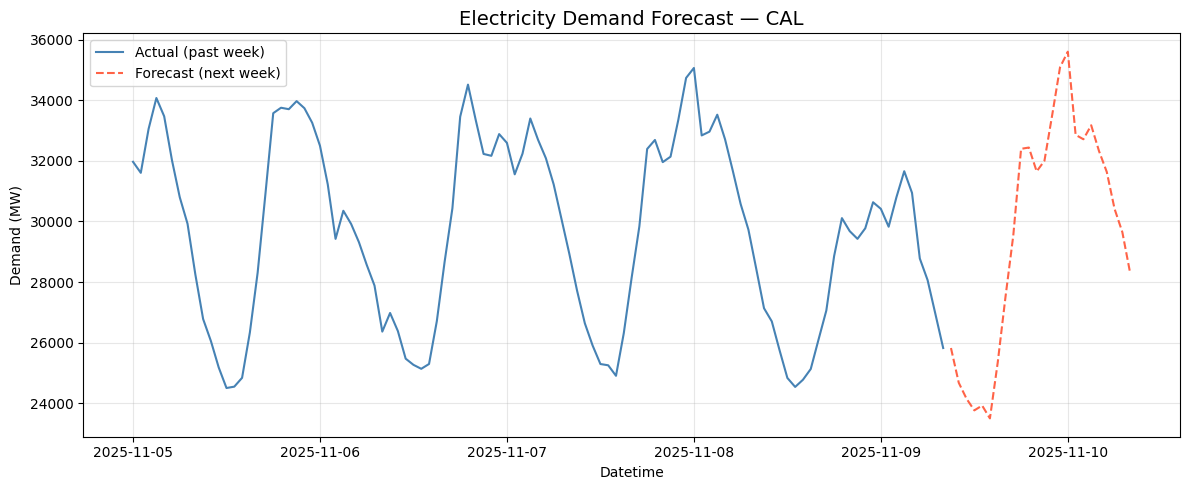

In [31]:
import matplotlib.pyplot as plt

region = "CAL"  # change to 'TEX', 'NE', etc.

# Forecasts
forecasts = []
for r, g in df.groupby("region"):
    yhat = forecast_region(g)
    forecasts.append(pd.DataFrame({
        "region": r,
        "datetime": yhat.index,
        "forecast_MW": yhat.values
    }))
# Remove duplicate datetime values for each region
forecast_df = pd.concat(forecasts).drop_duplicates(subset=["region", "datetime"])


# Plot
region = "CAL"

actual = (
    df[df["region"] == region]
    .drop_duplicates(subset=["datetime"])  # Ensure no duplicate datetime values
    .set_index("datetime")["demand_MW"]
    .asfreq("H")
    .interpolate()
)
forecast = (
    forecast_df[forecast_df["region"] == region]
    .drop_duplicates(subset=["datetime"])  # Ensure no duplicate datetime values
    .set_index("datetime")["forecast_MW"]
)

plt.figure(figsize=(12,5))
plt.plot(actual[-7*24:], label="Actual (past week)", color="steelblue")
plt.plot(forecast, label="Forecast (next week)", color="tomato", linestyle="--")
plt.title(f"Electricity Demand Forecast — {region}", fontsize=14)
plt.xlabel("Datetime"); plt.ylabel("Demand (MW)")
plt.legend(); plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
